In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
balanced_train_dir = os.path.join(dataset_dir, 'balanced_train') # We're using the balanced dataset
test_dir = os.path.join(dataset_dir, 'test')

In [ ]:
#Set the parameter used to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

#Creation of the training, validation and test set

We exploit the directory hierarchy of our dataset to infer the classes from the
name of the directories, more details are present in the report about the choices taken.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="training",
    shuffle=True,
    seed=1024)

validation_dataset = image_dataset_from_directory(
    balanced_train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    subset="validation",
    shuffle=True,
    seed=1024)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 8100 files belonging to 18 classes.
Using 7290 files for training.
Found 8100 files belonging to 18 classes.
Using 810 files for validation.
Found 1112 files belonging to 18 classes.


In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)

Let's import the pre-trained model:

In [ ]:
from keras import applications

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(180, 180,3))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in base_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 21768352


# Feature extraction

Let's freeze all the layers in the convolution base:

In [ ]:
base_model.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in base_model.trainable_weights))

# Make sure you have frozen the correct layers
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

This is the number of trainable weights after freezing the conv base: 0
0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

Now we define the classifier that we will add on top of the convolutional base:

In [ ]:
from keras.applications import inception_v3

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = inception_v3.preprocess_input(x)
x = base_model(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(18, activation="softmax")(x)

optimizer = keras.optimizers.Adam(learning_rate=1e-2)

model = keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 2048)       0     

**Let's add Keras callbacks:**
*   Early stopping
*   ModelCheckpoint
*   ReduceLROnPlateau

In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=12),

    keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(dir_name, 'InceptionV3_feature_extraction_2.h5'),
    monitor='val_loss',
    save_best_only=True,
    ),

    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    )
]

Train the network:

In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
114/114 [==============================] - 1137s 9s/step - loss: 17.0371 - accuracy: 0.3007 - val_loss: 5.0647 - val_accuracy: 0.3877 - lr: 0.0100
Epoch 2/100
114/114 [==============================] - 38s 315ms/step - loss: 5.1593 - accuracy: 0.4490 - val_loss: 3.7368 - val_accuracy: 0.5210 - lr: 0.0100
Epoch 3/100
114/114 [==============================] - 36s 301ms/step - loss: 5.6311 - accuracy: 0.4664 - val_loss: 4.5746 - val_accuracy: 0.5333 - lr: 0.0100
Epoch 4/100
114/114 [==============================] - 34s 283ms/step - loss: 5.1623 - accuracy: 0.5107 - val_loss: 4.0924 - val_accuracy: 0.5667 - lr: 0.0100
Epoch 5/100
114/114 [==============================] - 36s 297ms/step - loss: 5.9481 - accuracy: 0.5022 - val_loss: 5.2733 - val_accuracy: 0.5296 - lr: 0.0100
Epoch 6/100
114/114 [==============================] - 33s 275ms/step - loss: 6.0674 - accuracy: 0.5228 - val_loss: 6.3199 - val_accuracy: 0.4914 - lr: 0.0100
Epoch 7/100
114/114 [=========================

Shows some plots to better evaluate the model:

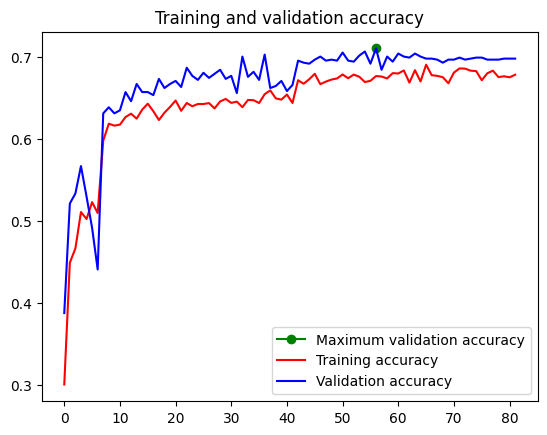

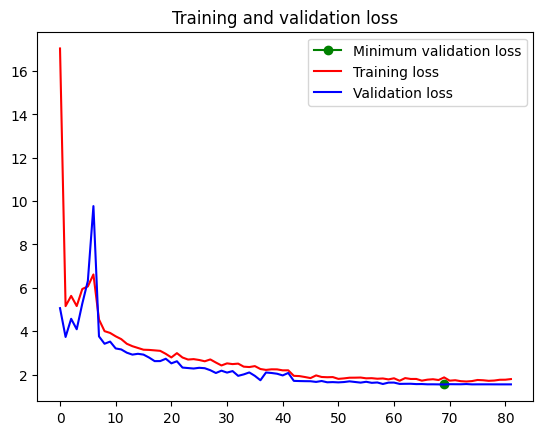

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

i = np.argmax(val_acc)
x_min = epochs[i]
y_min = val_acc[i]
plt.plot(x_min, y_min,'g',marker='o', label="Maximum validation accuracy")

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

i = np.argmin(val_loss)
x_min = epochs[i]
y_min = val_loss[i]
plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning

In [ ]:
filepath=os.path.join(dir_name, 'InceptionV3_feature_extraction_2.h5')
model=keras.models.load_model(filepath)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 2048)       0     

In [ ]:
model.layers[4].summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

Let's fine tune all the layers above the 268:

In [ ]:
model.layers[4].trainable = True
set_trainable = False

for layer in model.layers[4].layers[:268]:
  layer.trainable = False
for layer in model.layers[4].layers[268:]:
  layer.trainable = True

In [ ]:
# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers[4].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
model.layers[4].summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 89, 89, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 89, 89, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 180, 180, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 2048)       0     

Let's add the same Keras callbacks as before and train the model:



In [ ]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15),

    keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(dir_name, 'InceptionV3_fine_tuning.h5'),
    monitor='val_loss',
    save_best_only=True,
    ),

    keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    )
]



history = model.fit(train_dataset,
                    epochs=100,
                    callbacks=callbacks_list,
                    validation_data=validation_dataset
                    )

Epoch 1/100
114/114 [==============================] - 54s 343ms/step - loss: 1.6331 - accuracy: 0.6299 - val_loss: 1.2852 - val_accuracy: 0.7062 - lr: 1.0000e-04
Epoch 2/100
114/114 [==============================] - 37s 312ms/step - loss: 1.2293 - accuracy: 0.7004 - val_loss: 1.0817 - val_accuracy: 0.7370 - lr: 1.0000e-04
Epoch 3/100
114/114 [==============================] - 36s 303ms/step - loss: 0.9932 - accuracy: 0.7469 - val_loss: 1.0233 - val_accuracy: 0.7506 - lr: 1.0000e-04
Epoch 4/100
114/114 [==============================] - 36s 303ms/step - loss: 0.8092 - accuracy: 0.7879 - val_loss: 0.9317 - val_accuracy: 0.7630 - lr: 1.0000e-04
Epoch 5/100
114/114 [==============================] - 37s 300ms/step - loss: 0.6944 - accuracy: 0.8040 - val_loss: 0.8232 - val_accuracy: 0.7926 - lr: 1.0000e-04
Epoch 6/100
114/114 [==============================] - 37s 303ms/step - loss: 0.6364 - accuracy: 0.8195 - val_loss: 0.7514 - val_accuracy: 0.7988 - lr: 1.0000e-04
Epoch 7/100
114/114 [=

Plotting the Training and Validation Loss Curves:

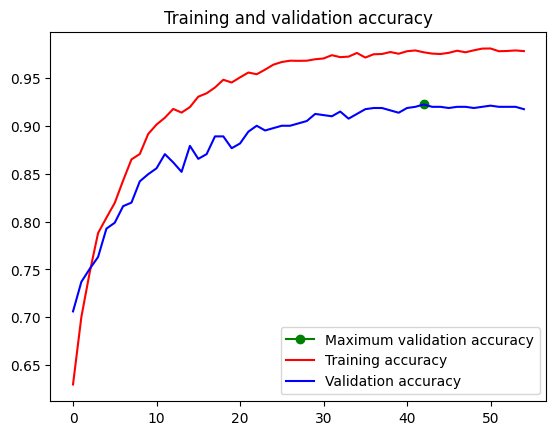

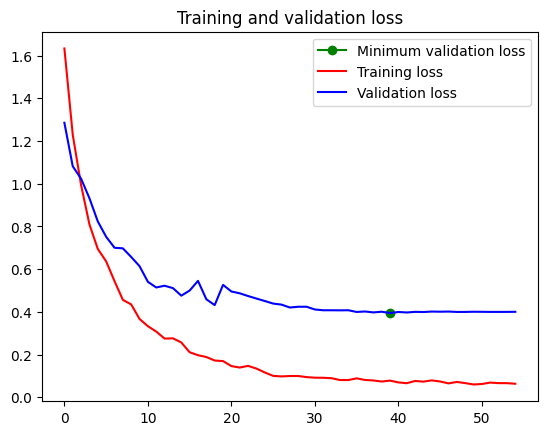

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

i = np.argmax(val_acc)
x_min = epochs[i]
y_min = val_acc[i]
plt.plot(x_min, y_min,'g',marker='o', label="Maximum validation accuracy")

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

i = np.argmin(val_loss)
x_min = epochs[i]
y_min = val_loss[i]
plt.plot(x_min, y_min,'g',marker='o', label="Minimum validation loss")

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)

#Save the rusults in the history dictionary
history.history["test_loss"] = test_loss
history.history["test_accuracy"] = test_acc

print('test_acc:', test_acc)
print('test_loss:', test_loss)

18/18 [==============================] - 189s 5s/step - loss: 1.6664 - accuracy: 0.7221
test_acc: 0.722122311592102
test_loss: 1.666382908821106


# Confusion matrix

In [ ]:
filepath=os.path.join(dir_name, 'InceptionV3_fine_tuning.h5')
model=keras.models.load_model(filepath)

Let's define a function to plot the Confusion Matrix:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(rounded_labels, predicted_labels, title):
  cm = confusion_matrix(rounded_labels, predicted_labels)
  fig = plt.figure(figsize = (9,8))
  ax1 = fig.add_subplot(1,1,1)
  ax1.set_title(title)
  sns.set(font_scale=1.1) #for label size
  sns.heatmap(cm, annot=True, annot_kws={"size": 10},cbar = True, cmap='Purples', fmt="d");
  ax1.set_ylabel('True Values',fontsize=14)
  ax1.set_xlabel('Predicted Values',fontsize=14)

  plt.show()

Function to print a table with the accuracies per class:


In [ ]:
def print_perc_table(class_names, rounded_labels, predicted_labels):

  counter_correct=[0 for i in range(18)]
  counter_errors=[0 for i in range(18)]
  counter_tot=[0 for i in range(18)]
  perc=[0 for i in range(18)]

  for count in range(len(rounded_labels)):
    if rounded_labels[count]==predicted_labels[count]:
      counter_correct[rounded_labels[count]]+=1
    else:
      counter_errors[rounded_labels[count]]+=1

  for i in range(18):
    counter_tot[i]=counter_correct[i]+counter_errors[i]
    perc[i]="{:.2f}".format(counter_correct[i]/counter_tot[i])

  data = np.array([np.array(class_names),np.array(perc)])
  return pd.DataFrame( perc,
    index=class_names,
    columns=["Accuracy"])

In [ ]:
def take_classes_size(directory):
  classes_size=[]
  classes_name=[]
  for dir in os.listdir(directory):
    dir_size=len(os.listdir(directory+"/"+dir))
    classes_size.append(dir_size)
    classes_name.append(dir)
    print(dir+": ",dir_size)
  return classes_name,classes_size

In [ ]:
classes_name, classes_size = take_classes_size(test_dir)
print("\nTotal paintings:", sum(classes_size))

Rene Magritte:  39
Edgar Degas:  240
Mikhail Vrubel:  35
Titian:  51
Albrecht Dürer:  66
Francisco Goya:  59
Andy Warhol:  37
Henri Matisse:  38
Paul Klee:  38
Pierre-Auguste Renoir:  68
Alfred Sisley:  52
Sandro Botticelli:  33
Marc Chagall:  48
Vincent van Gogh:  427
Amedeo Modigliani:  39
Pablo Picasso:  88
Paul Gauguin:  63
Rembrandt:  53

Total paintings: 1474


In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2/2 [==============================] - 0s 37ms/step


In [ ]:
class_names=test_dataset.class_names
rounded_labels=np.argmax(correct_labels, axis=1)

In [ ]:
print_perc_table(class_names, rounded_labels, predicted_labels)

,Accuracy
Albrecht Dürer,0.94
Alfred Sisley,0.81
Amedeo Modigliani,0.77
Andy Warhol,0.68
Edgar Degas,0.82
Francisco Goya,0.53
Henri Matisse,0.61
Marc Chagall,0.62
Mikhail Vrubel,0.44
Pablo Picasso,0.55


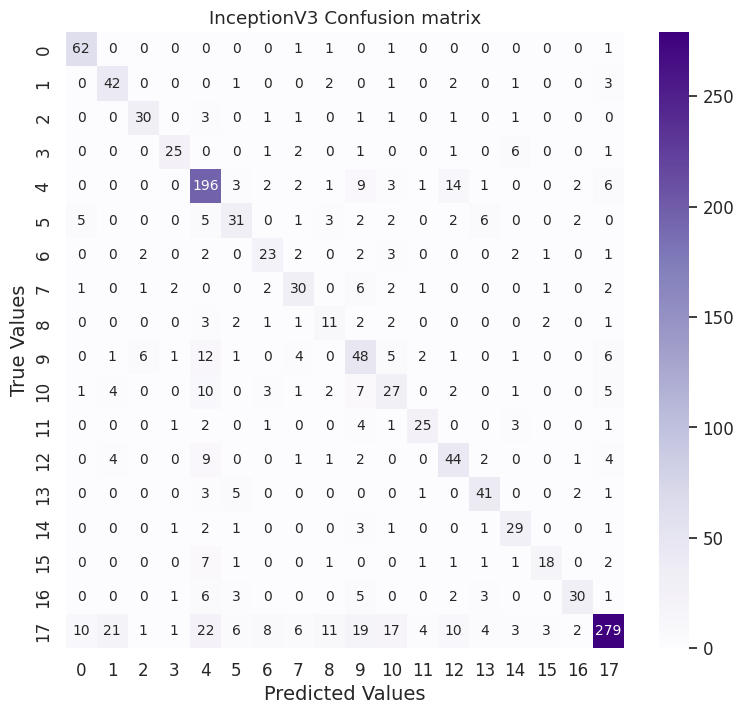

In [ ]:
plot_confusion_matrix(rounded_labels,predicted_labels,"InceptionV3 Confusion matrix")